In [14]:
!ls -l data

total 0
drwxrwxrwx@ 41 luke  staff  1312 Aug 25  2018 CroppedYaleB
drwx------@ 44 luke  staff  1408 Aug 24  2018 ORL


In [48]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [50]:
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))


ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [51]:
def add_noise(img, block_size=10, value=255):
    """
    Add block-occlusion noise to an image.

    Args:
        img: numpy array of the image.
        block_size: size of the square block.
        value: pixel value for the noise block.

    Returns:
        img with noise added.
    """
    x, y = np.random.randint(0, img.shape[0] - block_size), np.random.randint(0, img.shape[1] - block_size)
    img[x:x+block_size, y:y+block_size] = value
    return img


In [52]:
def load_data(root='data/CroppedYaleB', reduce=4, add_noise_flag=True, noise_block_size=12):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array with optional noise.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        add_noise_flag: whether to add noise to the images.
        noise_block_size: size of the noise block.
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):
            if fname.endswith('Ambient.pgm') or not fname.endswith('.pgm'):
                continue
                
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')  # Convert to grayscale

            img = img.resize([s//reduce for s in img.size])  # Reduce image size

            img = np.array(img)  # Use np.array to ensure the array is writable

            if add_noise_flag:
                img = add_noise(img, block_size=noise_block_size)  # Add noise to the image

            img = img.flatten()  # Flatten the image to a 1D array

            images.append(img)
            labels.append(i)

    images = np.stack(images, axis=1)  # Stack images horizontally
    labels = np.array(labels)

    return images, labels

In [54]:
X, Y = load_data(root='data/ORL', reduce=2, add_noise_flag=True, noise_block_size=12)
print('ORL dataset with noise: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))
X_yale, Y_yale = load_data(root='data/CroppedYaleB', reduce=4, add_noise_flag=True, noise_block_size=12)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yale.shape, Y_yale.shape))

ORL dataset with noise: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [55]:
def nmf(V, num_components, max_iter=100, error_limit=1e-4, random_state=None):
    """
    Perform Non-negative Matrix Factorization on the matrix V
    using the multiplicative update rule.
    """
    np.random.seed(random_state)
    m, n = V.shape
    W = np.abs(np.random.rand(m, num_components))
    H = np.abs(np.random.rand(num_components, n))

    for i in range(max_iter):
        H *= (W.T @ V) / (W.T @ W @ H + 1e-10)
        W *= (V @ H.T) / (W @ (H @ H.T) + 1e-10)
        if np.linalg.norm(V - W @ H, 'fro') < error_limit:
            break
    return W, H

In [56]:
# Applying NMF to ORL dataset
W, H = nmf(X, num_components=20, max_iter=200, error_limit=1e-3, random_state=42)
print("NMF on ORL dataset: W.shape = {}, H.shape = {}".format(W.shape, H.shape))

# Applying NMF to Extended YaleB dataset
W_yale, H_yale = nmf(X_yale, num_components=20, max_iter=200, error_limit=1e-3, random_state=42)
print("NMF on Extended YaleB dataset: W.shape = {}, H.shape = {}".format(W_yale.shape, H_yale.shape))

NMF on ORL dataset: W.shape = (2576, 20), H.shape = (20, 400)
NMF on Extended YaleB dataset: W.shape = (2016, 20), H.shape = (20, 2414)


In [57]:
def compute_rre(V, W, H):
    """
    Compute Relative Reconstruction Errors (RRE).

    Args:
        V: original data matrix.
        W: basis matrix from NMF.
        H: coefficient matrix from NMF.

    Returns:
        rre: relative reconstruction error.
    """
    reconstruction = W @ H
    return np.linalg.norm(V - reconstruction, 'fro') / np.linalg.norm(V, 'fro')

In [58]:
rre = compute_rre(X, W, H)
print("Relative Reconstruction Error:", rre)


Relative Reconstruction Error: 0.22068481898451411


In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

def k_means_clustering(H, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_labels = kmeans.fit_predict(H.T)  # 注意 H 需要转置因为 sklearn 期望样本是行
    return predicted_labels

def calculate_accuracy(true_labels, predicted_labels):
    # 计算精度，这里可能需要映射预测标签到真实标签
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

def calculate_nmi(true_labels, predicted_labels):
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return nmi

In [64]:
def evaluate_nmf_performance(X, Y, num_components, n_clusters, num_trials=5):
    accuracies = []
    nmis = []

    for _ in range(num_trials):
        # 随机采样90%的数据
        sample_indices = np.random.choice(X.shape[1], size=int(0.9 * X.shape[1]), replace=False)
        X_sample = X[:, sample_indices]
        Y_sample = Y[sample_indices]

        # 应用 NMF
        W, H = nmf(X_sample, num_components)

        # 应用 K-means
        predicted_labels = k_means_clustering(H, Y_sample, n_clusters)

        # 计算精度和NMI
        accuracy = calculate_accuracy(Y_sample, predicted_labels)
        nmi = calculate_nmi(Y_sample, predicted_labels)

        accuracies.append(accuracy)
        nmis.append(nmi)

    # 计算平均和标准偏差
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_nmi = np.mean(nmis)
    std_nmi = np.std(nmis)

    return (mean_accuracy, std_accuracy, mean_nmi, std_nmi)

# 用例执行
num_components = 30  # 你可以根据实际情况调整
n_clusters = len(np.unique(Y))  # 假设 Y 包含了所有可能的类别
results = evaluate_nmf_performance(X, Y, num_components, n_clusters)
print(f"Average Accuracy: {results[0]} ± {results[1]}")
print(f"Normalized Mutual Information: {results[2]} ± {results[3]}")

Average Accuracy: 0.019444444444444445 ± 0.006573421981221795
Normalized Mutual Information: 0.5338037059632007 ± 0.015995036804050684


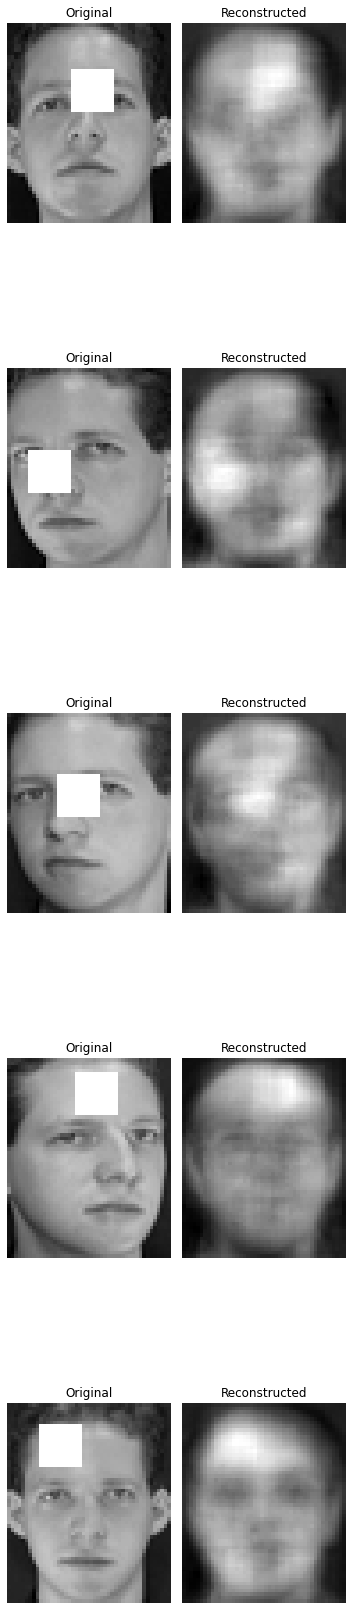

In [59]:
def show_reconstructed_images(X, W, H, img_shape, indices=[0, 1, 2]):
    """
    Show original and reconstructed images side by side.

    Args:
        X: original data matrix.
        W: basis matrix from NMF.
        H: coefficient matrix from NMF.
        img_shape: shape of each image.
        indices: list of image indices to show.
    """
    reconstruction = W @ H
    fig, axes = plt.subplots(nrows=len(indices), ncols=2, figsize=(5, 5*len(indices)))
    for idx, ax in zip(indices, axes):
        ax[0].imshow(X[:, idx].reshape(img_shape), cmap='gray')
        ax[0].set_title("Original")
        ax[0].axis('off')
        ax[1].imshow(reconstruction[:, idx].reshape(img_shape), cmap='gray')
        ax[1].set_title("Reconstructed")
        ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# 显示重建的图像示例
show_reconstructed_images(X, W, H, (112//2, 92//2), indices=[0, 1, 2, 3, 4])